import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.cuda.amp import autocast, GradScaler
from collections import deque
import random

# Define quantum gates
HADAMARD = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
T_GATE = np.array([[1, 0], [0, np.exp(1j * np.pi / 4)]])
CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])


# Define the quantum environment
class QuantumGateEnv:
    def __init__(self, max_steps=10):
        self.max_steps = max_steps
        self.time_step = 0
        self.state = None
        self.target = None
        self.gate = None

    def reset(self, gate="H"):
        self.time_step = 0
        self.gate = gate
        if gate == "H":
            self.state = np.array([1 + 0j, 0 + 0j], dtype=np.complex128)  # |0> state
            self.target = HADAMARD
            self.theoretical_state = np.dot(self.target, self.state)
        elif gate == "T":
            self.state = np.array([1 + 0j, 0 + 0j], dtype=np.complex128)  # |0> state
            self.target = T_GATE
            self.theoretical_state = np.dot(self.target, self.state)
        elif gate == "CNOT":
            self.state = np.array(
                [0 + 0j, 0 + 0j, 0 + 0j, 1 + 0j], dtype=np.complex128
            )  # |11> state
            self.target = CNOT
            self.theoretical_state = np.dot(self.target, self.state)
        return self._get_full_real_state()

    def _get_full_real_state(self):
        return np.concatenate((self.state.real, self.state.imag))

    def _get_control_matrix(self, action):
        theta = np.pi / 8  # Rotation angle
        if action == 0:  # Rotation around X-axis
            return np.array(
                [
                    [np.cos(theta / 2), -1j * np.sin(theta / 2)],
                    [-1j * np.sin(theta / 2), np.cos(theta / 2)],
                ]
            )
        elif action == 1:  # Rotation around Y-axis
            return np.array(
                [
                    [np.cos(theta / 2), -np.sin(theta / 2)],
                    [np.sin(theta / 2), np.cos(theta / 2)],
                ]
            )
        elif action == 2:  # Rotation around Z-axis
            return np.array([[np.exp(-1j * theta / 2), 0], [0, np.exp(1j * theta / 2)]])
        else:
            raise ValueError("Invalid action")

    def step(self, action):
        self.time_step += 1
        control_matrix = self._get_control_matrix(action)
        next_state = np.dot(control_matrix, self.state)
        self.state = next_state
        reward = -self.infidelity(next_state) if self.time_step == self.max_steps else 0
        done = self.time_step == self.max_steps
        return self._get_full_real_state(), reward, done

    def infidelity(self, final_complex_state):
        fidelity = np.abs(np.vdot(self.theoretical_state, final_complex_state)) ** 2
        return 1 - fidelity


# Dueling Double Deep Q-Network
class DDDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DDDQN, self).__init__()
        self.fc1 = nn.Linear(state_size * 2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.value_fc = nn.Linear(64, 1)
        self.advantage_fc = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_fc(x)
        advantage = self.advantage_fc(x)
        q_vals = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_vals


# DDDQN Agent
class DDDQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.device = device

        self.model = DDDQN(state_size, action_size).to(device)
        self.target_model = DDDQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        self.scaler = GradScaler()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        state = torch.FloatTensor(state).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return np.argmax(q_values.cpu().numpy())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        self.model.train()
        self.target_model.eval()

        with autocast():
            q_vals = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_vals = self.target_model(next_states).max(1)[0]
            target_q_vals = rewards + (self.gamma * next_q_vals * (1 - dones))
            loss = self.criterion(q_vals, target_q_vals)

        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


# Training the agent
def train_agent(agent, env, episodes, target_update, fidelity_threshold):
    total_rewards = []
    fidelities = []
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(env.max_steps):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        agent.replay()
        if e % target_update == 0:
            agent.update_target_model()
        total_rewards.append(total_reward)
        fidelity = 1 - env.infidelity(env.state)
        fidelities.append(fidelity)
        if e % 100 == 0:
            print(
                f"Episode: {e}/{episodes}, Total Reward: {total_reward}, Fidelity: {fidelity:.4f}, Epsilon: {agent.epsilon:.2f}"
            )
        if fidelity >= fidelity_threshold:
            print(f"Early stopping at episode {e} with fidelity {fidelity}")
            break
    return total_rewards, fidelities


# Hyperparameters
EPISODES = 10000
TARGET_UPDATE = 100
FIDELITY_THRESHOLD = 1 - 1e-4

# Initialize the environment and agent
state_size = 1  # One qubit
action_size = 3  # Rotations around X, Y, Z axes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = QuantumGateEnv()
agent = DDDQNAgent(state_size, action_size, device)

# Train the agent
total_rewards, fidelities = train_agent(
    agent, env, EPISODES, TARGET_UPDATE, FIDELITY_THRESHOLD
)

In [1]:
from qiskit import QuantumCircuit

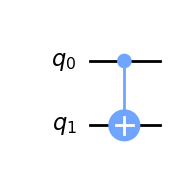

In [6]:
qc=QuantumCircuit(2)
qc.cx(0,1)
qc.draw(output="mpl")

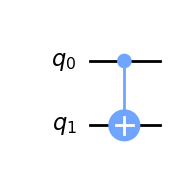

In [9]:
qc.decompose().draw(output='mpl',style='clifford')